In [1]:
import torch
from torch import tensor
import torchvision
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange
import pandas as pd
from sklearn.metrics import roc_auc_score
import numpy as np

In [2]:
class FairLogReg(nn.Module):
    def __init__(self, D, warm_start = None):
        super(FairLogReg, self).__init__()
        if warm_start is not None:
            self.theta = torch.nn.Parameter(warm_start, requires_grad=True)
        else:
            self.theta = torch.nn.Parameter(torch.zeros(D), requires_grad=True)
        self.old_theta = tensor(float("Inf"))

    def forward(self, x):
        return x.mv(self.theta)


Pick between COMPAS and Adult data sets

In [3]:
from sklearn.calibration import LabelEncoder
from sklearn.discriminant_analysis import StandardScaler


def get_adults_datset(n_samples, with_val):
    col_names = [
        "age",
        "workclass",
        "fnlwgt",
        "education",
        "education-num",
        "marital-status",
        "occupation",
        "relationship",
        "race",
        "sex",
        "capital-gain",
        "capital-loss",
        "hours-per-week",
        "native-country",
        "income",
    ]

    # Load data
    data = (
        pd.read_csv("/root/fairclassification/datasets/adult.data", names=col_names)
        .sample(frac=1.0, random_state=42)
        .reset_index(drop=True)
    )

    # Handle missing values
    data = data.replace(" ?", pd.NA)
    data = data.dropna()

    if with_val:
        data = data.iloc[:-5000].copy()

    # Define sensitive attribute
    sensitive_attr = tensor(data['sex'].apply(lambda x: not 'Female' in x).values)
    # data["sex"].apply(lambda x: "Female" in x).values

    # Define target variable
    y = LabelEncoder().fit_transform(data["income"])

    # Define features
    X = data.drop(["sex", "income"], axis=1)

    # Normalization for numeric features
    num_cols = X.select_dtypes(include=[np.number]).columns
    scaler = StandardScaler()
    X[num_cols] = scaler.fit_transform(X[num_cols])

    # One-hot encoding for categorical features
    X = pd.get_dummies(X).values
    X = torch.from_numpy(X.astype("float32"))  # Convert to float32 for PyTorch
    y = torch.from_numpy(y.astype("float32"))
    # sensitive_attr = torch.from_numpy(sensitive_attr.astype("long"))
    if not with_val:
        X = X[-5000:, :]
        y = y[-5000:]
        sensitive_attr = sensitive_attr[-5000:]
    return X[:n_samples, :], y[:n_samples], sensitive_attr[:n_samples]


In [4]:
def get_compas_dataset(n_samples, with_val):
    col_names = [
        "sex",
        "age",
        "race",
        "juv_fel_count",
        "juv_misd_count",
        "juv_other_count",
        "priors_count",
        "c_charge_degree",
        "two_year_recid",
    ]

    # Load data
    data = (
        pd.read_csv("/root/fairclassification/datasets/compas-scores-two-years.csv")
        .sample(frac=1.0, random_state=42)
        .reset_index(drop=True)
    )

    data = data.loc[:, col_names]

    # Handle missing values
    data = data.replace(" ?", pd.NA)
    data = data.dropna()

    if with_val:
        data = data.iloc[:-2000].copy()
    else:
        data = data.iloc[-2000:].copy()

    # Define sensitive attribute
    sensitive_attr = tensor(data["race"].apply(lambda x: "African-American" in x).values)

    # Define target variable
    y = LabelEncoder().fit_transform(data["two_year_recid"])

    # Define features
    X = data.drop(["race", "two_year_recid"], axis=1)

    # Normalization for numeric features
    num_cols = X.select_dtypes(include=[np.number]).columns
    scaler = StandardScaler()
    X[num_cols] = scaler.fit_transform(X[num_cols])

    # One-hot encoding for categorical features
    X = pd.get_dummies(X).values
    X = torch.from_numpy(X.astype("float32"))  # Convert to float32 for PyTorch
    y = torch.from_numpy(y.astype("float32"))
    return X[:n_samples, :], y[:n_samples], sensitive_attr[:n_samples]

In [5]:
# Comment one out

# def get_data(filename):
#     df = pd.read_csv("data/COMPAS/" + filename + ".csv")
#     s = tensor(df['race'] == "Caucasian")
#     y = tensor(df['two_year_recid'] == 0).float()
#     X = tensor(df.drop(columns=['race','sex','sex-race','two_year_recid']).values).float()
#     X = torch.cat((torch.ones(X.shape[0],1), X), dim=1)
#     return (X,y,s)

# lam_regs = 2. ** np.array([-3, -3, -3, -3, -3])
# lam_regs = 10. ** np.array([-3, -3, -3, -3, -3])
# lam_regs = np.zeros_like(lam_regs)
def get_data(filename):
    df = pd.read_csv("data/Adult/" + filename + ".csv")
    s = tensor(df['sex'] == "Male")
    y = tensor(df['income-per-year'] == ">50K").float()
    X = tensor(df.drop(columns=['sex','race','income-per-year','race-sex','capital-gain', 'capital-loss']).values).float()
    X = torch.cat((torch.ones(X.shape[0],1), X), dim=1)
    return (X,y,s)
lam_regs = 2. ** np.array([-14, -12, -12, -12, -13])

In [110]:
form="linear"
sum_form=1 # 1 for sum, -1 for difference
unfairness = "eop"

if unfairness == "eoo":
    eoo=True
    eo=False
elif unfairness == "dp":
    eoo=False
    eo=False
else:
    eoo=False
    eo=True



In [111]:
if form == "logistic":
    def g(outputs):
        return -F.logsigmoid(-outputs).sum()
elif form == "hinge":
    relu = torch.nn.ReLU()
    def g(outputs):
        return relu(outputs+1).sum()
elif form == "linear":
    def g(outputs):
        return outputs.sum()
else:
    raise ValueError("Pick a valid form!")

ploss = nn.BCEWithLogitsLoss()
def floss(outputs, sens_attr, Pa, Pb):
    return sum_form * g(sum_form * outputs[sens_attr])/Pa + g(- outputs[~sens_attr])/Pb

In [112]:
dataset = 'compas'

if dataset == 'compas':
    get_data = get_compas_dataset
elif dataset == 'adult':
    get_data = get_adults_datset

(Xs, ys, ss) = ([None] * 1, [None] * 1, [None] * 1)
(Xts, yts, sts) = ([None] * 1, [None] * 1, [None] * 1)
for i in range(1):
    (Xs[i], ys[i], ss[i]) = get_data(n_samples=50000, with_val=True)
    (Xts[i], yts[i], sts[i]) = get_data(n_samples=1000, with_val=False)

In [113]:
# (Xs, ys, ss) = ([None] * 5, [None] * 5, [None] * 5)
# (Xts, yts, sts) = ([None] * 5, [None] * 5, [None] * 5)
# for i in range(5):
#     (Xs[i], ys[i], ss[i]) = get_data("train" + str(i))
#     (Xts[i], yts[i], sts[i]) = get_data("test" + str(i))

In [114]:
def make_closure(model, optimizer, lam_fair, lam_reg, X, y, s, Pa, Pb):
    def closure():
        assert not torch.isnan(model.theta).any()
        optimizer.zero_grad()
        outputs = model(X)
        if eoo:
            loss = ploss(outputs,y) + lam_reg * (model.theta**2).mean() + lam_fair/outputs.shape[0] * floss(outputs[y.bool()], s[y.bool()], Pa, Pb)
        elif eo:
            loss = ploss(outputs,y) + lam_reg * (model.theta**2).mean() + 0.5*lam_fair/outputs.shape[0] * (floss(outputs[y.bool()], s[y.bool()], Pa[0], Pb[0]) + floss(outputs[~y.bool()], s[~y.bool()], Pa[1], Pb[1]))
        else:
            loss = ploss(outputs,y) + lam_reg * (model.theta**2).mean() + lam_fair/outputs.shape[0] * floss(outputs, s, Pa, Pb)
        loss.backward()
        return loss
    return closure

In [115]:
def train_model(X,y,s,lam_fair=0, lam_reg=0, warm_start=None):
    if eoo:
        (Pa, Pb) = ((s & y.bool()).float().mean(), (~s&y.bool()).float().mean())
    if eo:
        Pa = [(s & y.bool()).float().mean(), (s & ~y.bool()).float().mean()]
        Pb = [(~s & y.bool()).float().mean(), (~s & ~y.bool()).float().mean()]
    else:
        (Pa, Pb) = (s.float().mean(), 1 - s.float().mean())
    model = FairLogReg(X.shape[1], warm_start=warm_start)
    if form == "hingexxx":
        optimizer = optim.Adam(model.parameters(), lr=1)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
    else:
        optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1)
    closure = make_closure(model, optimizer, lam_fair, lam_reg, X, y, s, Pa, Pb)
    for t in trange(500):
        loss = optimizer.step(closure)
        if form == "hingexxx":
            scheduler.step(loss)
        diff = (model.old_theta - model.theta).abs().max()
        if diff < 1e-10:
            break
        model.old_theta = model.theta.clone().detach()
    return (model, t)

In [116]:
def get_summary(model, X,y,s, lam_fair=0, lam_reg=0):
    (Pa, Pb) = (s.float().mean(), 1 - s.float().mean())
    outputs = model(X)
    accuracy = (y == (outputs >= 0)).float().mean()
    if eoo:
        # unfairness = (outputs[y.bool() & s] >= 0).float().mean() - (outputs[y.bool() & ~s] >= 0).float().mean()
        unfairness = (torch.sigmoid(outputs[y.bool() & s])).float().mean() - (torch.sigmoid(outputs[y.bool() & ~s])).float().mean()
        relaxation = 1/outputs.shape[0] * floss(outputs[y.bool()], s[y.bool()], Pa, Pb)
    elif eo:
        unfairness_y1 = 0.5*torch.abs((torch.sigmoid(outputs[y.bool() & s])).float().mean() - (torch.sigmoid(outputs[y.bool() & ~s])).float().mean())
        unfairness_y0 = 0.5*torch.abs((torch.sigmoid(outputs[~y.bool() & s])).float().mean() - (torch.sigmoid(outputs[~y.bool() & ~s])).float().mean())
        # unfairness_y1 = 0.5*torch.abs((outputs[y.bool() & s]>0).float().mean() - (outputs[y.bool() & ~s]>0).float().mean())
        # unfairness_y0 = 0.5*torch.abs((outputs[~y.bool() & s]>0).float().mean() - (outputs[~y.bool() & ~s]>0).float().mean())
        unfairness = unfairness_y0 + unfairness_y1
        relaxation = 1/outputs.shape[0] * floss(outputs[y.bool()], s[y.bool()], Pa, Pb)
    else:
        unfairness = (torch.sigmoid(outputs[s])).float().mean() - (torch.sigmoid(outputs[~s])).float().mean()
        # unfairness = (outputs[s]>0).float().mean() - (outputs[~s]>0).float().mean()
        relaxation = 1/outputs.shape[0] * floss(outputs, s, Pa, Pb)
    loss = ploss(outputs,y)
    return(accuracy, unfairness, loss, relaxation)

In [117]:
# for weighting baseline, if desired
def get_weighed_loss(X,y,s):
    wobs = y * 10 + s
    wobs[wobs==0.] = (wobs==0.).float().mean()
    wobs[wobs==1.] = (wobs==1.).float().mean()
    wobs[wobs==11.] = (wobs==11.).float().mean()
    wobs[wobs==10.] = (wobs==10.).float().mean()
    wy = (y - (y==0).float().mean()).abs()
    ws = (s.float() - (s==0).float().mean()).abs()
    wexp = ws * wy
    return nn.BCEWithLogitsLoss(weight = (wexp/wobs))

In [118]:
sc = ss[0]
print(sc)

tensor([False,  True,  True,  ..., False,  True, False])


In [119]:
# df = pd.DataFrame(columns = ['Split', 'Lam_fair', 'Type', 'Accuracy', 'Unfairness', 'Ploss', 'Relaxation'])
warm_starts = [None] * 1
lfs = np.arange(0.0, 0.3, 0.01) #0.02)
df = pd.DataFrame()
for lam_fair in lfs:
    for i in range(1):
        (model,t) = train_model(Xs[i],ys[i],ss[i], lam_fair = lam_fair, lam_reg = lam_regs[i], warm_start=warm_starts[i])
     #    (model,t) = train_model(Xs[i],ys[i],ss[i], lam_fair = lam_fair, lam_reg = 0, warm_start=warm_starts[i])
        warm_starts[i] = model.theta.clone().detach()
        (train_accuracy, train_unfairness, train_loss, train_relax) = get_summary(model, Xs[i], ys[i], ss[i], lam_fair = lam_fair, lam_reg = lam_regs[i])
        d = {"Split": [i],
             "Type": ["Train"],
             "Lam_fair": [lam_fair.item()],
             'Accuracy': [train_accuracy.item()], 
             'Unfairness': [train_unfairness.item()],
             'Ploss': [train_loss.item()],
             'Relaxation': [train_relax.item()]}
        df = pd.concat([df, pd.DataFrame(d)], axis=0, ignore_index=True)
        (test_accuracy, test_unfairness, test_loss, test_relax) = get_summary(model, Xts[i], yts[i], sts[i], lam_fair = lam_fair, lam_reg = lam_regs[i])
        d = {"Split": [i],
             "Type": ["Test"],
             "Lam_fair": [lam_fair.item()],
             'Accuracy': [test_accuracy.item()], 
             'Unfairness': [test_unfairness.item()],
             'Ploss': [test_loss.item()],
             'Relaxation': [test_relax.item()]}
        print(d)
        df = pd.concat([df, pd.DataFrame(d)], axis=0, ignore_index=True)
    print(lam_fair)


  3%|▎         | 17/500 [00:07<03:18,  2.43it/s]


{'Split': [0], 'Type': ['Test'], 'Lam_fair': [0.0], 'Accuracy': [0.6620000004768372], 'Unfairness': [0.10620817542076111], 'Ploss': [0.6226617097854614], 'Relaxation': [0.3119054436683655]}
0.0


  3%|▎         | 14/500 [00:04<02:46,  2.91it/s]


{'Split': [0], 'Type': ['Test'], 'Lam_fair': [0.01], 'Accuracy': [0.6610000133514404], 'Unfairness': [0.10327711701393127], 'Ploss': [0.6221479773521423], 'Relaxation': [0.29832935333251953]}
0.01


  2%|▏         | 10/500 [00:05<04:38,  1.76it/s]


{'Split': [0], 'Type': ['Test'], 'Lam_fair': [0.02], 'Accuracy': [0.6629999876022339], 'Unfairness': [0.10035611689090729], 'Ploss': [0.6218308210372925], 'Relaxation': [0.2852500081062317]}
0.02


  4%|▎         | 18/500 [00:07<03:28,  2.31it/s]


{'Split': [0], 'Type': ['Test'], 'Lam_fair': [0.03], 'Accuracy': [0.6660000085830688], 'Unfairness': [0.09745518863201141], 'Ploss': [0.6216985583305359], 'Relaxation': [0.2726800739765167]}
0.03


  3%|▎         | 16/500 [00:05<02:49,  2.85it/s]


{'Split': [0], 'Type': ['Test'], 'Lam_fair': [0.04], 'Accuracy': [0.6669999957084656], 'Unfairness': [0.09457287192344666], 'Ploss': [0.6217386722564697], 'Relaxation': [0.26058170199394226]}
0.04


  4%|▍         | 19/500 [00:06<02:34,  3.12it/s]


{'Split': [0], 'Type': ['Test'], 'Lam_fair': [0.05], 'Accuracy': [0.6690000295639038], 'Unfairness': [0.09170591831207275], 'Ploss': [0.6219398379325867], 'Relaxation': [0.248912513256073]}
0.05


  2%|▏         | 12/500 [00:04<03:02,  2.67it/s]


{'Split': [0], 'Type': ['Test'], 'Lam_fair': [0.06], 'Accuracy': [0.6679999828338623], 'Unfairness': [0.08885304629802704], 'Ploss': [0.622292160987854], 'Relaxation': [0.23764188587665558]}
0.06


  2%|▏         | 10/500 [00:03<03:10,  2.57it/s]


{'Split': [0], 'Type': ['Test'], 'Lam_fair': [0.07], 'Accuracy': [0.6650000214576721], 'Unfairness': [0.08601255714893341], 'Ploss': [0.6227868795394897], 'Relaxation': [0.2267397940158844]}
0.07


  3%|▎         | 15/500 [00:07<03:56,  2.05it/s]


{'Split': [0], 'Type': ['Test'], 'Lam_fair': [0.08], 'Accuracy': [0.6660000085830688], 'Unfairness': [0.08318302035331726], 'Ploss': [0.6234161257743835], 'Relaxation': [0.21617862582206726]}
0.08


  3%|▎         | 17/500 [00:04<02:18,  3.48it/s]


{'Split': [0], 'Type': ['Test'], 'Lam_fair': [0.09], 'Accuracy': [0.6650000214576721], 'Unfairness': [0.0803629606962204], 'Ploss': [0.6241729855537415], 'Relaxation': [0.20593298971652985]}
0.09


  3%|▎         | 15/500 [00:05<03:04,  2.63it/s]


{'Split': [0], 'Type': ['Test'], 'Lam_fair': [0.1], 'Accuracy': [0.6589999794960022], 'Unfairness': [0.07755109667778015], 'Ploss': [0.6250511407852173], 'Relaxation': [0.19597981870174408]}
0.1


  3%|▎         | 14/500 [00:04<02:43,  2.98it/s]


{'Split': [0], 'Type': ['Test'], 'Lam_fair': [0.11], 'Accuracy': [0.6589999794960022], 'Unfairness': [0.07474710047245026], 'Ploss': [0.6260449290275574], 'Relaxation': [0.1863003671169281]}
0.11


  3%|▎         | 13/500 [00:03<02:22,  3.41it/s]


{'Split': [0], 'Type': ['Test'], 'Lam_fair': [0.12], 'Accuracy': [0.6579999923706055], 'Unfairness': [0.07194846868515015], 'Ploss': [0.6271499991416931], 'Relaxation': [0.17686964571475983]}
0.12


  2%|▏         | 10/500 [00:06<04:54,  1.67it/s]


{'Split': [0], 'Type': ['Test'], 'Lam_fair': [0.13], 'Accuracy': [0.6570000052452087], 'Unfairness': [0.06915512681007385], 'Ploss': [0.6283618211746216], 'Relaxation': [0.16767215728759766]}
0.13


  3%|▎         | 17/500 [00:06<02:56,  2.74it/s]


{'Split': [0], 'Type': ['Test'], 'Lam_fair': [0.14], 'Accuracy': [0.6589999794960022], 'Unfairness': [0.06636613607406616], 'Ploss': [0.6296765804290771], 'Relaxation': [0.15869084000587463]}
0.14


  3%|▎         | 14/500 [00:04<02:39,  3.05it/s]


{'Split': [0], 'Type': ['Test'], 'Lam_fair': [0.15], 'Accuracy': [0.6549999713897705], 'Unfairness': [0.06358091533184052], 'Ploss': [0.6310910582542419], 'Relaxation': [0.14990994334220886]}
0.15


  4%|▎         | 18/500 [00:05<02:27,  3.27it/s]


{'Split': [0], 'Type': ['Test'], 'Lam_fair': [0.16], 'Accuracy': [0.6499999761581421], 'Unfairness': [0.0607987642288208], 'Ploss': [0.6326023936271667], 'Relaxation': [0.14131470024585724]}
0.16


  3%|▎         | 15/500 [00:06<03:20,  2.42it/s]


{'Split': [0], 'Type': ['Test'], 'Lam_fair': [0.17], 'Accuracy': [0.6480000019073486], 'Unfairness': [0.05801911652088165], 'Ploss': [0.6342081427574158], 'Relaxation': [0.13289134204387665]}
0.17


  3%|▎         | 14/500 [00:04<02:22,  3.42it/s]


{'Split': [0], 'Type': ['Test'], 'Lam_fair': [0.18], 'Accuracy': [0.640999972820282], 'Unfairness': [0.05524151027202606], 'Ploss': [0.6359061598777771], 'Relaxation': [0.1246267631649971]}
0.18


  2%|▏         | 11/500 [00:06<05:10,  1.57it/s]


{'Split': [0], 'Type': ['Test'], 'Lam_fair': [0.19], 'Accuracy': [0.6420000195503235], 'Unfairness': [0.052465423941612244], 'Ploss': [0.6376948952674866], 'Relaxation': [0.11650880426168442]}
0.19


  3%|▎         | 14/500 [00:05<03:00,  2.69it/s]


{'Split': [0], 'Type': ['Test'], 'Lam_fair': [0.2], 'Accuracy': [0.6359999775886536], 'Unfairness': [0.049690574407577515], 'Ploss': [0.63957279920578], 'Relaxation': [0.1085258200764656]}
0.2


  3%|▎         | 13/500 [00:05<03:44,  2.17it/s]


{'Split': [0], 'Type': ['Test'], 'Lam_fair': [0.21], 'Accuracy': [0.6330000162124634], 'Unfairness': [0.04691731929779053], 'Ploss': [0.6415383815765381], 'Relaxation': [0.10066892206668854]}
0.21


  2%|▏         | 10/500 [00:05<04:09,  1.96it/s]


{'Split': [0], 'Type': ['Test'], 'Lam_fair': [0.22], 'Accuracy': [0.6320000290870667], 'Unfairness': [0.04414376616477966], 'Ploss': [0.643592119216919], 'Relaxation': [0.09292314946651459]}
0.22


  3%|▎         | 14/500 [00:05<03:24,  2.38it/s]


{'Split': [0], 'Type': ['Test'], 'Lam_fair': [0.23], 'Accuracy': [0.6290000081062317], 'Unfairness': [0.04137028753757477], 'Ploss': [0.6457329392433167], 'Relaxation': [0.08528048545122147]}
0.23


  4%|▎         | 18/500 [00:07<03:11,  2.52it/s]


{'Split': [0], 'Type': ['Test'], 'Lam_fair': [0.24], 'Accuracy': [0.6240000128746033], 'Unfairness': [0.038596734404563904], 'Ploss': [0.6479607820510864], 'Relaxation': [0.07773133367300034]}
0.24


  2%|▏         | 12/500 [00:04<02:58,  2.73it/s]


{'Split': [0], 'Type': ['Test'], 'Lam_fair': [0.25], 'Accuracy': [0.6200000047683716], 'Unfairness': [0.03582274913787842], 'Ploss': [0.6502758264541626], 'Relaxation': [0.07026619464159012]}
0.25


  3%|▎         | 16/500 [00:05<02:46,  2.91it/s]


{'Split': [0], 'Type': ['Test'], 'Lam_fair': [0.26], 'Accuracy': [0.6169999837875366], 'Unfairness': [0.033048197627067566], 'Ploss': [0.6526784896850586], 'Relaxation': [0.06287610530853271]}
0.26


  4%|▍         | 22/500 [00:06<02:21,  3.38it/s]


{'Split': [0], 'Type': ['Test'], 'Lam_fair': [0.27], 'Accuracy': [0.6100000143051147], 'Unfairness': [0.030272722244262695], 'Ploss': [0.655169665813446], 'Relaxation': [0.05555199086666107]}
0.27


  3%|▎         | 13/500 [00:04<02:44,  2.95it/s]


{'Split': [0], 'Type': ['Test'], 'Lam_fair': [0.28], 'Accuracy': [0.6039999723434448], 'Unfairness': [0.027496173977851868], 'Ploss': [0.6577503681182861], 'Relaxation': [0.048285190016031265]}
0.28


  3%|▎         | 17/500 [00:06<03:07,  2.58it/s]

{'Split': [0], 'Type': ['Test'], 'Lam_fair': [0.29], 'Accuracy': [0.597000002861023], 'Unfairness': [0.024718254804611206], 'Ploss': [0.6604219675064087], 'Relaxation': [0.041067127138376236]}
0.29


In [105]:
df

,Split,Type,Lam_fair,Accuracy,Unfairness,Ploss,Relaxation
0,0,Train,0.00,0.681435,0.093638,0.609795,0.247244
1,0,Test,0.00,0.662000,0.106208,0.622662,0.311905
2,0,Train,0.01,0.682777,0.090952,0.609888,0.236076
3,0,Test,0.01,0.661000,0.103277,0.622148,0.298329
4,0,Train,0.02,0.683353,0.088270,0.610159,0.225333
5,0,Test,0.02,0.663000,0.100356,0.621831,0.285250
6,0,Train,0.03,0.683161,0.085605,0.610593,0.215022
7,0,Test,0.03,0.666000,0.097455,0.621699,0.272680
8,0,Train,0.04,0.682010,0.082956,0.611180,0.205107
9,0,Test,0.04,0.667000,0.094573,0.621739,0.260582


In [106]:
# df = pd.read_csv("./adult_dp_results.csv")
df_0 = df.loc[(df['Split']==0) & (df['Type']=='Test')].copy()


In [107]:
df_0['Unfairness'] = np.abs(df_0['Unfairness'])

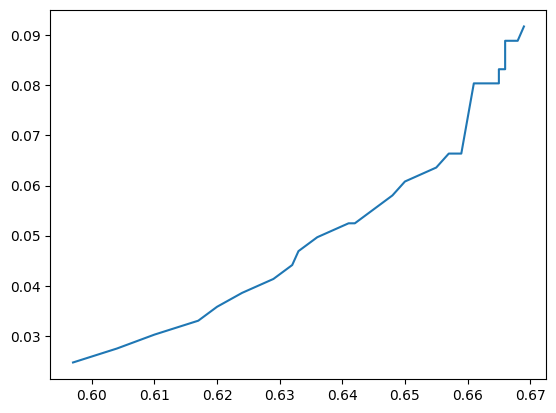

In [108]:
import matplotlib.pyplot as plt

df_0 = df_0.sort_values(by='Accuracy')
unfairness_vals = df_0['Unfairness'].values
min_unfairness = [np.min(unfairness_vals[i:]) for i in range(len(unfairness_vals))]
plt.plot(df_0['Accuracy'], min_unfairness)




In [109]:
# df.to_csv("./adult_dp_results.csv")
df_0['min_unfairness_vals'] = min_unfairness
df_0.to_csv("../compas_linear_eo_test.csv", index=False)